In [1]:
import sys
sys.path.append('./src/')
import os
os.chdir("../")

In [2]:
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from preprocessing import encode_labels


In [3]:
config_file = "config.json"
with open(config_file, 'r') as f:
    config = json.load(f)

In [19]:
model_path = "./models/model_20240229152028.pkl"
model, class_names = joblib.load(model_path)
class_map= {class_names[i]:i for i in range(len(class_names))}
class_map


{'constant': 0, 'multi': 1, 'normal': 2, 'rapid': 3}

In [5]:
test_data_path = config['processed_test_data_path']
df_test = pd.read_csv(test_data_path)
y0_test = df_test['cluster']
X_test = df_test.drop(columns={'cluster','well'})
y_test, _ = encode_labels(y0_test)
y_test_pred = model.predict(X_test)
y_test_pred

array([0, 2, 2, 3, 0, 1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0,
       2, 2, 1, 0, 0, 2, 3, 1, 2, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 2,
       1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 1, 2,
       0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2,
       2])

In [6]:
norm_conf_mx = confusion_matrix(y_test, y_test_pred,normalize='true')
norm_conf_mx

array([[0.375     , 0.0625    , 0.5625    , 0.        ],
       [0.25      , 0.1875    , 0.5625    , 0.        ],
       [0.43333333, 0.06666667, 0.5       , 0.        ],
       [0.18181818, 0.18181818, 0.45454545, 0.18181818]])

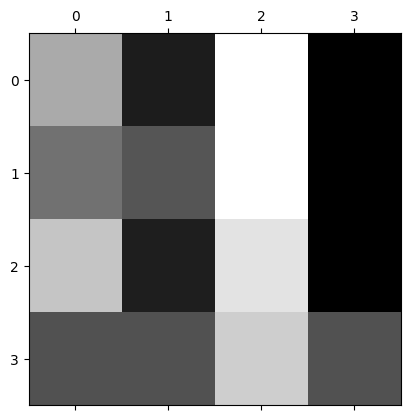

In [7]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

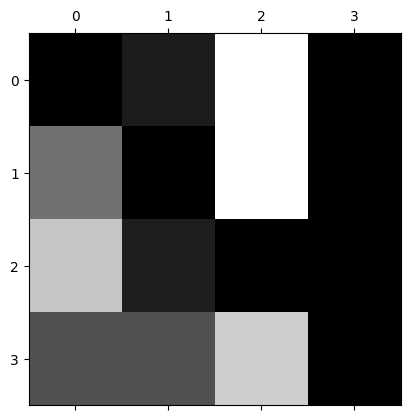

In [8]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* The column of class 2 is bright, which tells you that many samples get misclassified as 2s. 
* 
* sample 2 is confused with sample 0 
* Sample 3 is all over the place, it gets confused with 0, 1, and mostly with  2.
* never, anyclass is confused as sample 3

**How can we reduce the false 2s?**

In [37]:
(df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p == 0")
)


,well,y,p
7,well_132,0,0
21,well_251,0,0
25,well_271,0,0
26,well_275,0,0
31,well_306,0,0
38,well_35,0,0
40,well_357,0,0
60,well_47,0,0
66,well_514,0,0
67,well_516,0,0


In [38]:
(df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p == 2")
)


,well,y,p
2,well_120,0,2
6,well_128,0,2
9,well_142,0,2
10,well_143,0,2
14,well_161,0,2
16,well_190,0,2
18,well_2,0,2
20,well_250,0,2
22,well_259,0,2
23,well_266,0,2


In [44]:
well_id = 'well_120'
df_well = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
 .groupby('well')
 .get_group(well_id)
 .sort_values(['date'])
 .filter(['date','value'])
)

,date,value
65,1977-03-01,1.771429
129,1977-04-01,1.843750
195,1977-05-01,0.481928
259,1977-06-01,0.000000
332,1977-07-01,0.717949
...,...,...
17759,1998-11-01,5.687500
17810,1998-12-01,5.000000
17862,1999-01-01,5.476190
17911,1999-02-01,5.200000
